In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multitest import multipletests
from itertools import combinations
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams["svg.fonttype"] = "none"


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\mizbili\AppData\Local\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start(

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.





Summary of the MLMR
                           Mixed Linear Model Regression Results
Model:                        MixedLM             Dependent Variable:             Pain_Score
No. Observations:             273                 Method:                         REML      
No. Groups:                   44                  Scale:                          0.1244    
Min. group size:              5                   Log-Likelihood:                 -154.9075 
Max. group size:              7                   Converged:                      Yes       
Mean group size:              6.2                                                           
--------------------------------------------------------------------------------------------
                                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------
Intercept                                          1.269    0.116 10.972 0.0

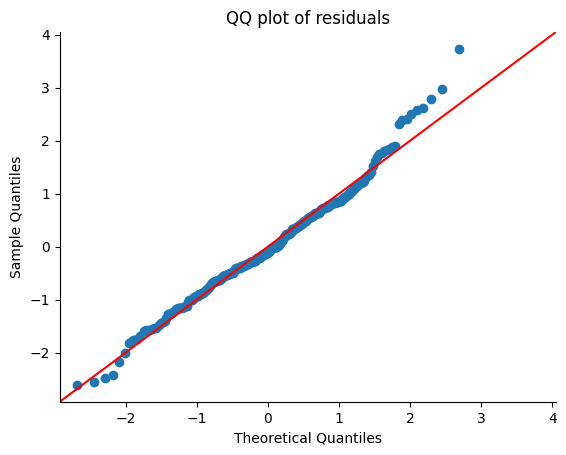



Pairwise Analyses for each time point

Estimated marginal means at Time_point = -1:
  SHAM_Male: 1.2591
  LNIO_Male: 1.0048
  SHAM_Female: 1.3161
  LNIO_Female: 1.1520

Pairwise comparisons (adjusted for multiple testing):
Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant
SHAM_Male vs LNIO_Male | 0.2542 | 0.1443 | 1.762 | 0.07924 | 0.2377 | False
SHAM_Male vs SHAM_Female | -0.0570 | 0.1913 | -0.298 | 0.7657 | 0.7657 | False
SHAM_Male vs LNIO_Female | 0.1070 | 0.1913 | 0.560 | 0.5762 | 0.6915 | False
LNIO_Male vs SHAM_Female | -0.3113 | 0.1704 | -1.827 | 0.06881 | 0.2377 | False
LNIO_Male vs LNIO_Female | -0.1472 | 0.1704 | -0.864 | 0.3884 | 0.6583 | False
SHAM_Female vs LNIO_Female | 0.1641 | 0.2116 | 0.775 | 0.4389 | 0.6583 | False

Estimated marginal means at Time_point = 3:
  SHAM_Male: 1.2974
  LNIO_Male: 1.3542
  SHAM_Female: 1.3617
  LNIO_Female: 1.4419

Pairwise comparisons (adjusted for multiple testing):
Group1 vs Group2 | Mean Diff | SE D

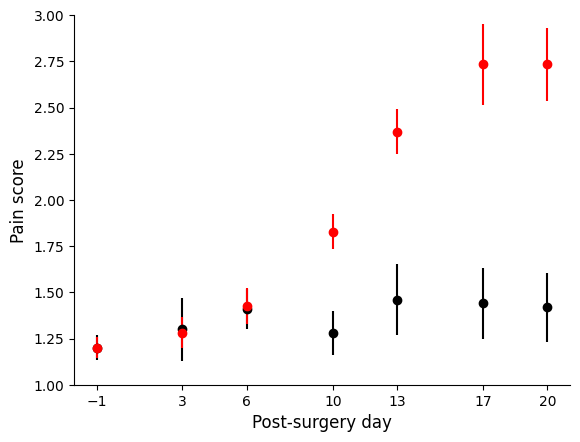



Pain score figure for Females


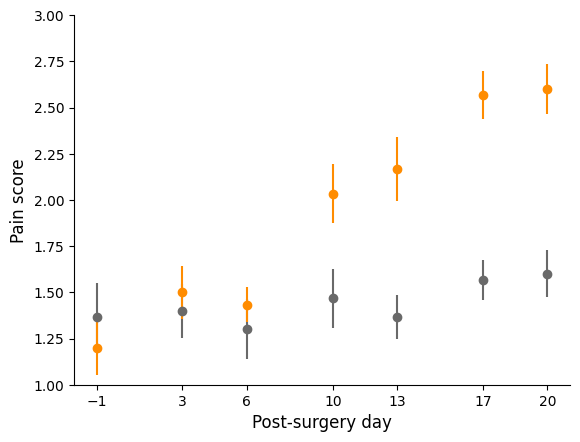

In [2]:
df_taken=pd.read_csv('VF_dataframe.csv')

list_categories_order=['SHAM_Male','LNIO_Male','SHAM_Female','LNIO_Female']

#perform MLMR
df_taken['Animal_Condition_Sex'] = pd.Categorical(df_taken['Animal_Condition_Sex'], categories=list_categories_order)
model = mixedlm(
    "Pain_Score ~ C(Animal_Condition_Sex) * Time_point",
    data=df_taken,
    groups=df_taken["Animal_Name"],
)
result = model.fit()
print()
print()
print('Summary of the MLMR')
print(result.summary())

# Add residuals and fitted values to dataframe
df_taken['residuals'] = result.resid
df_taken['fitted'] = result.fittedvalues

# QQ plot of residuals
sm.qqplot(df_taken['residuals'], line='45', fit = True)
plt.title('QQ plot of residuals')
plt.show()


# === Define parameters for estimated marginal means calculation ===
categories = df_taken['Animal_Condition_Sex'].cat.categories.tolist()
intercept = result.params['Intercept']
time_coef = result.params.get('Time_point', 0)

# Function to get coefficient or 0 if not present (e.g., reference category)
def get_coef(name):
    return result.params.get(name, 0)


print()
print()
print('Pairwise Analyses for each time point')
list_time_point=[-1,3,6,10,13,17,20]
for t_value in list_time_point:
    
    # === Calculate estimated marginal means for each group at time t_value ===
    marginal_means = {}
    for cat in categories:
        cond_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]")
        interaction_coef = get_coef(f"C(Animal_Condition_Sex)[T.{cat}]:Time_point")
        mean = intercept + cond_coef + time_coef * t_value + interaction_coef * t_value
        marginal_means[cat] = mean
    
    print(f"\nEstimated marginal means at Time_point = {t_value}:")
    for k, v in marginal_means.items():
        print(f"  {k}: {v:.4f}")
    
    # === Prepare covariance matrix for contrasts ===
    cov = result.cov_params()
    
    # Degrees of freedom approximation:
    df_resid = result.df_resid if hasattr(result, 'df_resid') else result.nobs - len(result.params)
    
    # === Compute pairwise contrasts ===
    alpha = 0.05
    pairwise_results = []
    
    for cat1, cat2 in combinations(categories, 2):
        # Difference in marginal means
        diff = marginal_means[cat1] - marginal_means[cat2]
        
        #compute manually var of marginal_means_diff
        if cat1==list_categories_order[0]:
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Time_point"
            list_var_diff=[
            cov[param_name_cat2][param_name_cat2],
            t_value*t_value*cov[param_name_cat2_IC][param_name_cat2_IC],
            2*t_value*cov[param_name_cat2][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
            
        elif cat2==list_categories_order[0]:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Time_point"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            t_value*t_value*cov[param_name_cat1_IC][param_name_cat1_IC],
            2*t_value*cov[param_name_cat1][param_name_cat1_IC],
            ]
            var_diff=np.sum(list_var_diff)
        
        else:
            param_name_cat1 = "C(Animal_Condition_Sex)[T."+cat1+"]"
            param_name_cat2 = "C(Animal_Condition_Sex)[T."+cat2+"]"
            param_name_cat1_IC = "C(Animal_Condition_Sex)[T."+cat1+"]:Time_point"
            param_name_cat2_IC = "C(Animal_Condition_Sex)[T."+cat2+"]:Time_point"
            list_var_diff=[
            cov[param_name_cat1][param_name_cat1],
            cov[param_name_cat2][param_name_cat2],
            t_value*t_value*cov[param_name_cat1_IC][param_name_cat1_IC],
            t_value*t_value*cov[param_name_cat2_IC][param_name_cat2_IC],
            -2*cov[param_name_cat1][param_name_cat2],
            2*t_value*cov[param_name_cat1][param_name_cat1_IC],
            -2*t_value*cov[param_name_cat1][param_name_cat2_IC],
            -2*t_value*cov[param_name_cat2][param_name_cat1_IC],
            2*t_value*cov[param_name_cat2][param_name_cat2_IC],
            -2*t_value*t_value*cov[param_name_cat1_IC][param_name_cat2_IC],
            ]
            var_diff=np.sum(list_var_diff)
        

        
        se_diff = np.sqrt(var_diff)
        t_stat = diff / se_diff
        pval = 2 * scipy.stats.t.sf(np.abs(t_stat), df=df_resid)  # two-sided p-value
    
        pairwise_results.append((cat1, cat2, diff, se_diff, t_stat, pval))
    
    # === Multiple testing correction (Benjamini-Hochberg FDR) ===
    pvals = [x[5] for x in pairwise_results]
    reject, pvals_corrected, _, _ = multipletests(pvals, alpha=alpha, method='fdr_bh')
    
    # === Print results ===
    print("\nPairwise comparisons (adjusted for multiple testing):")
    print("Group1 vs Group2 | Mean Diff | SE Diff | t-stat | p-value | p-value_adj | Significant")
    for i, (cat1, cat2, diff, se_diff, t_stat, pval) in enumerate(pairwise_results):
        print(f"{cat1} vs {cat2} | {diff:.4f} | {se_diff:.4f} | {t_stat:.3f} | {pval:.4g} | {pvals_corrected[i]:.4g} | {reject[i]}")





#create figure for Male
print()
print()
print('Pain score figure for Males')
list_animal_condition=['SHAM_Male','LNIO_Male']
for animal_condition in list_animal_condition:
    for time_point in list_time_point:
        df_trans = df_taken.loc[df_taken['Animal_Condition_Sex']==animal_condition]
        df_trans = df_trans.loc[df_trans['Time_point']==time_point]
        if 'SHAM' in animal_condition:
            plt.errorbar(time_point,np.mean(df_trans['Pain_Score']),yerr=scipy.stats.sem(df_trans['Pain_Score']),fmt='o',color='k')
        else:
            plt.errorbar(time_point,np.mean(df_trans['Pain_Score']),yerr=scipy.stats.sem(df_trans['Pain_Score']),fmt='o',color='r')
            
plt.xlabel('Post-surgery day',fontsize=12)
plt.ylabel('Pain score',fontsize=12)
plt.xticks([-1,3,6,10,13,17,20])
plt.ylim(1,3)
plt.savefig('VF_Male.svg')
plt.show()


#create figure for Female
print()
print()
print('Pain score figure for Females')
list_animal_condition=['SHAM_Female','LNIO_Female']
for animal_condition in list_animal_condition:
    for time_point in list_time_point:
        df_trans = df_taken.loc[df_taken['Animal_Condition_Sex']==animal_condition]
        df_trans = df_trans.loc[df_trans['Time_point']==time_point]
        if 'SHAM' in animal_condition:
            plt.errorbar(time_point,np.mean(df_trans['Pain_Score']),yerr=scipy.stats.sem(df_trans['Pain_Score']),fmt='o',color='dimgrey')
        else:
            plt.errorbar(time_point,np.mean(df_trans['Pain_Score']),yerr=scipy.stats.sem(df_trans['Pain_Score']),fmt='o',color='darkorange')
            
plt.xlabel('Post-surgery day',fontsize=12)
plt.ylabel('Pain score',fontsize=12)
plt.xticks([-1,3,6,10,13,17,20])
plt.ylim(1,3)
plt.savefig('VF_Female.svg')
plt.show()